Now we need to check if we can calculate the optical path length difference in a simplified potential to obtain the phase change in the electron wave. We then need to check if we can calculate the phase difference by integrating the potential our electron passes through. We will try and do this for an electron with a long wavelength so we can easily plot the wavelength and phase shift as the electron refracts through the potential. We will also try and use a simple linear potential. 

In [1]:
import sympy as sp
from sympy import Piecewise, DiracDelta
from sympy.core.numbers import pi, oo
from IPython.display import display
from latex2sympy2 import latex2sympy
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, epsilon_0, e, m_e, h
import numba
%matplotlib widget


Again set up constants and sympy symbols, and define the equation in sympy, and make a lambda function out of it.

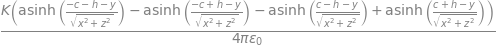

In [2]:
#Initialise printing
sp.init_printing()

#Create mathematical symbols
x, y, z = sp.symbols('x y z', real = True)

e = e #-1.60217662e-19 #unit C
m = m_e #9.10938356e-31 #unit kg
h_planck = h #6.62607015e-34 #unit J . s 
c_l = c #2.99792458e8 #unit m/s
eps_0_val = epsilon_0 #8.85418782e-12 #permittivity unit F/m
eps = abs(e)/(2*m*c_l**2) #eps as defined in Hawkes, different from the permittivity of free space. 

K_val = 3.31 #unit e/nm - convert to coulombs per m? 
K_val_SI = (3.31*abs(e))/1e-9 #C/m

x, y, z, K, eps_0, c, h = sp.symbols('x y z K epsilon_0 c h')
a, b = sp.symbols('a b')

phi_wires_pozzi = (K/(4*pi*eps_0))*((sp.asinh((c-(y-h))/sp.sqrt(x**2+z**2)))-(sp.asinh((-c-(y-h))/sp.sqrt(x**2+z**2)))+(sp.asinh((-c-(y+h))/sp.sqrt(x**2+z**2)))-(sp.asinh((c-(y+h))/sp.sqrt(x**2+z**2))))
display(phi_wires_pozzi)

c_val = 0.5e-3
gap = 90e-9
h_val = -(c_val+gap)
phi_wires_pozzi_simple = phi_wires_pozzi.subs({K:K_val_SI, eps_0:eps_0_val, pi:np.pi, c:c_val, h:h_val})
phi_wires_pozzi_lambda_simple = sp.lambdify([x, y, z], phi_wires_pozzi_simple, 'numpy')

#Calculate the E-Field so we can plot it. 
Ex = -1*phi_wires_pozzi_simple.diff(x)
Ey = -1*phi_wires_pozzi_simple.diff(y)
Ez = -1*phi_wires_pozzi_simple.diff(z)

E_lambda = sp.lambdify([x, y, z], [Ex, Ey, Ez], 'numpy')

Plot the view of the electron as it moves towards the potential in the x-y plane. 

Text(0, 0.5, 'y (m)')

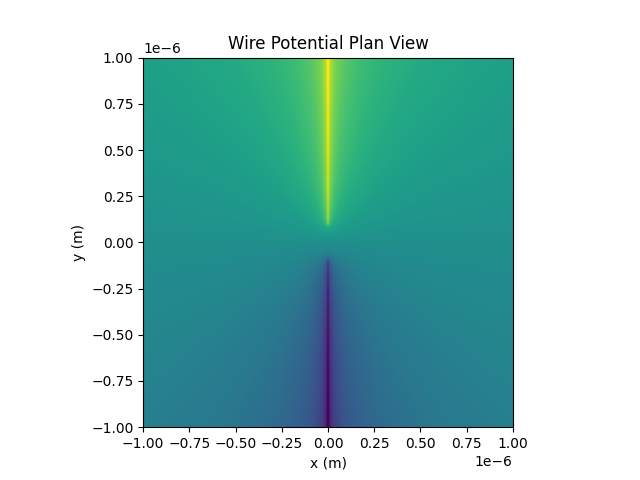

In [3]:
z_ = np.linspace(-1, 1, 1000)
plan_figure, plan_ax = plt.subplots()

scale = 1000e-9
x_line, xstep = np.linspace(-scale, scale, 300, retstep = True)
y_line, ystep = np.linspace(-scale, scale, 300, retstep = True)
x_grid, y_grid = np.meshgrid(x_line, y_line)
z_grid = 0*np.ones(x_grid.shape)

potential_image = phi_wires_pozzi_lambda_simple(x_grid, y_grid, 0)
plan_ax.imshow(potential_image, extent=[-scale, scale, -scale, scale])
#plan_ax.contour(potential_image, 25, linewidths = 0.25, colors = 'k', extent = [-1, 1, -1, 1], origin = 'upper')
plan_ax.set_title('Wire Potential Plan View')
plan_ax.set_xlabel('x (m)')
plan_ax.set_ylabel('y (m)')

Plot a side view of the potential 

Text(0, 0.5, 'x (m)')

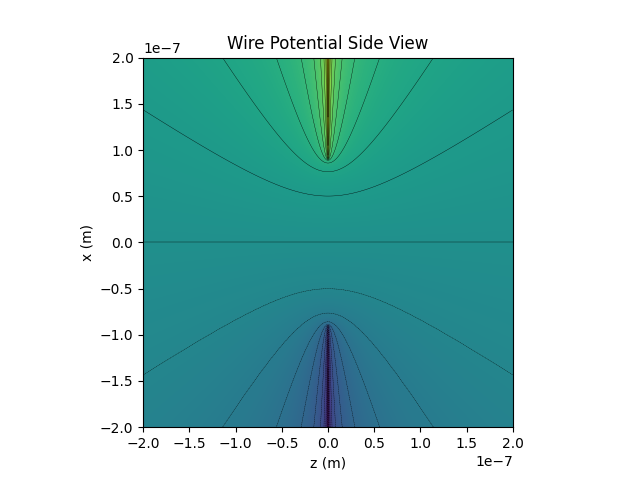

In [4]:
zy_figure, zy_ax = plt.subplots()
z_line, zstep = np.linspace(-200e-9, 200e-9, 1000, retstep = True)
y_line, ystep = np.linspace(-200e-9, 200e-9, 1000, retstep = True)
z_grid, y_grid = np.meshgrid(y_line, z_line)
x_grid = 0*np.ones(y_grid.shape)
potential_image = phi_wires_pozzi_lambda_simple(x_grid, y_grid, z_grid)
zy_ax.imshow(potential_image, extent=[-200e-9, 200e-9, -200e-9, 200e-9], origin = 'upper')
zy_ax.contour(potential_image, 25, linewidths = 0.25, colors = 'k', extent = [-200e-9, 200e-9, -200e-9, 200e-9], origin = 'upper')
zy_ax.set_title('Wire Potential Side View')
zy_ax.set_xlabel('z (m)')
zy_ax.set_ylabel('x (m)')

Plot the E-Fields

Text(0, 0.5, 'x (m)')

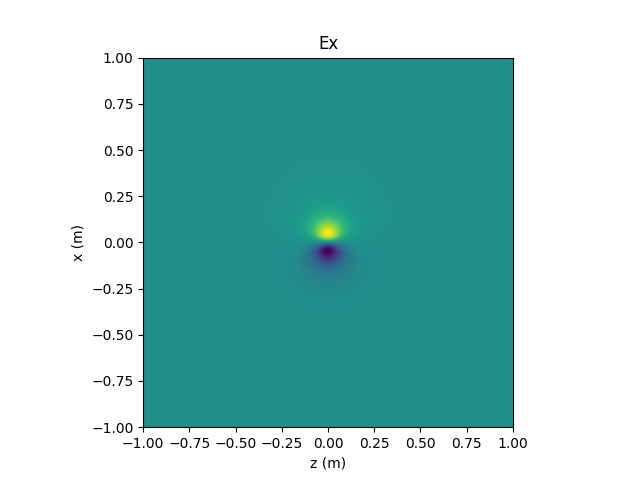

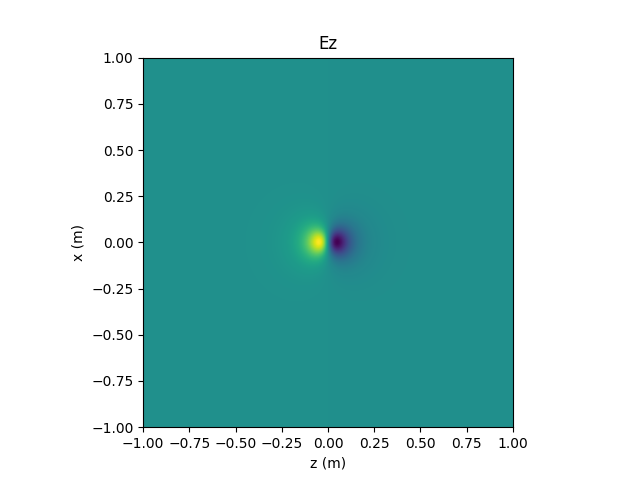

In [5]:
Ex_figure, Ex_ax = plt.subplots()
Ez_line, Ezstep = np.linspace(-1, 1, 500, retstep = True)
Ex_line, Exstep = np.linspace(-1, 1, 500, retstep = True)
Ez_grid, Ex_grid = np.meshgrid(Ex_line, Ez_line)
Ey_grid = 0.1*np.ones(Ex_grid.shape)
efield_image = E_lambda(Ex_grid, Ey_grid, Ez_grid)[0]
Ex_ax.imshow(efield_image, extent=[-1, 1, -1, 1], origin = 'upper')
Ex_ax.set_title('Ex')
Ex_ax.set_xlabel('z (m)')
Ex_ax.set_ylabel('x (m)')

Ez_figure, Ez_ax = plt.subplots()
Ez_line, Ezstep = np.linspace(-1, 1, 500, retstep = True)
Ex_line, Exstep = np.linspace(-1, 1, 500, retstep = True)
Ez_grid, Ex_grid = np.meshgrid(Ex_line, Ez_line)
Ey_grid = 0.1*np.ones(Ex_grid.shape)
efield_image = E_lambda(Ex_grid, Ey_grid, Ez_grid)[2]
Ez_ax.imshow(efield_image, extent=[-1, 1, -1, 1], origin = 'upper')
Ez_ax.set_title('Ez')
Ez_ax.set_xlabel('z (m)')
Ez_ax.set_ylabel('x (m)')

Again make our ODE solver equation

In [6]:
def odedopri(f,  x0,  y0,  x1,  tol,  hmax,  hmin,  maxiter, args=()):
    a21 = (1.0/5.0)
    a31 = (3.0/40.0)
    a32 = (9.0/40.0)
    a41 = (44.0/45.0)
    a42 = (-56.0/15.0)
    a43 = (32.0/9.0)
    a51 = (19372.0/6561.0)
    a52 = (-25360.0/2187.0)
    a53 = (64448.0/6561.0)
    a54 = (-212.0/729.0)
    a61 = (9017.0/3168.0)
    a62 = (-355.0/33.0)
    a63 = (46732.0/5247.0)
    a64 = (49.0/176.0)
    a65 = (-5103.0/18656.0)
    a71 = (35.0/384.0)
    a72 = (0.0)
    a73 = (500.0/1113.0)
    a74 = (125.0/192.0)
    a75 = (-2187.0/6784.0)
    a76 = (11.0/84.0)
    c2 = (1.0 / 5.0)
    c3 = (3.0 / 10.0)
    c4 = (4.0 / 5.0)
    c5 = (8.0 / 9.0)
    c6 = (1.0)
    c7 = (1.0)
    b1 = (35.0/384.0)
    b2 = (0.0)
    b3 = (500.0/1113.0)
    b4 = (125.0/192.0)
    b5 = (-2187.0/6784.0)
    b6 = (11.0/84.0)
    b7 = (0.0)
    b1p = (5179.0/57600.0)
    b2p = (0.0)
    b3p = (7571.0/16695.0)
    b4p = (393.0/640.0)
    b5p = (-92097.0/339200.0)
    b6p = (187.0/2100.0)
    b7p = (1.0/40.0)
    x = x0
    y = y0
    h = hmax
    X = np.zeros(maxiter)
    X[0] = x0
    Y = np.zeros((maxiter, len(y0)))
    Y[0] = y0
    
    #We need a special step counter because the ODE dormand prince 
    #method will do a step again with a smaller step size if the error is too large
    step = 1
    for i in range(maxiter):
       # /* Compute the function values */
       K1 = f(x,       y, *args)
       K2 = f(x + c2*h, y+h*(a21*K1), *args)
       K3 = f(x + c3*h, y+h*(a31*K1+a32*K2), *args)
       K4 = f(x + c4*h, y+h*(a41*K1+a42*K2+a43*K3), *args)
       K5 = f(x + c5*h, y+h*(a51*K1+a52*K2+a53*K3+a54*K4), *args)
       K6 = f(x + h, y+h*(a61*K1+a62*K2+a63*K3+a64*K4+a65*K5), *args)
       K7 = f(x + h, y+h*(a71*K1+a72*K2+a73*K3+a74*K4+a75*K5+a76*K6), *args)
       error = abs((b1-b1p)*K1+(b3-b3p)*K3+(b4-b4p)*K4+(b5-b5p)*K5 +
                   (b6-b6p)*K6+(b7-b7p)*K7)
       #Error in X controls tolerance
       error = max(error)
       # error control
       if error != 0.0:
           delta = 0.84 * pow(tol / error, (1.0/5.0))
       else:
           delta = np.inf
       if (error < tol):
          x = x + h
          X[step] = x
          y = y + h * (b1*K1+b3*K3+b4*K4+b5*K5+b6*K6)
          Y[step, :] = y
          step+=1
       if (delta <= 0.1):
          h = h * 0.1
       elif (delta >= 4.0):
          h = h * 4.0
       else:
          h = delta * h
       if (h > hmax):
          h = hmax
       if (x >= x1):
          print('reached end')
          break
       elif (x + h > x1):
          h = x1 - x
       elif (h < hmin):
          print('Below hmin')
          break
    return X, Y, step

And make our potential function that we need to put into our ODE solver

In [7]:
def make_potential_and_efield(phi, phi_0, x, y, z, eps):
    
    phi_hat = (phi_0-phi)*(1+eps*(phi_0-phi))
    
    #Get E field function. Notice there is no negative sign, as the way hawkes uses phi_hat, there is no minus before it (Equation 3.22).
    dphi_hat_wires_electron_dx = phi_hat.diff(x)
    dphi_hat_wires_electron_dy = phi_hat.diff(y)
    dphi_hat_wires_electron_dz = phi_hat.diff(z)

    phi_hat_wires_electron_lambda = numba.jit(sp.lambdify([x, y, z], phi_hat, 'numpy'))
    dphi_hat_wires_electron_lambda = numba.jit(sp.lambdify([x, y, z], [dphi_hat_wires_electron_dx, dphi_hat_wires_electron_dy, dphi_hat_wires_electron_dz], 'numpy'))
    
    return phi_hat_wires_electron_lambda, dphi_hat_wires_electron_lambda

Trajectory equation of motion from Hawkes

In [8]:
@numba.jit(nopython = True)
def trajectory_equation_of_motion(z, x, phi_hat_lambda, dphi_hat_lambda, phi_hat_0):
    
    p = np.sqrt(1+x[1]**2+x[3]**2) #obtain slope of ray
    phi_hat = phi_hat_lambda(x[0], x[2], z) #evaluate potential
    dphi_hat_x, dphi_hat_y, dphi_hat_z = dphi_hat_lambda(x[0], x[2], z) #evaluate the efield

    return [x[1], (p**2)/(2*phi_hat)*(dphi_hat_x-x[1]*dphi_hat_z), x[3], (p**2)/(2*phi_hat)*(dphi_hat_y-x[3]*dphi_hat_z), (phi_hat/phi_hat_0)**(1/2)*p] #evaluate the velocities and accelerations, [vx, ax, vy, ay]


In [9]:
#Define acceleration potential of electron
phi_0 = 2e5 #unit V #2e5

phi_hat_lambda, dphi_hat_lambda = make_potential_and_efield(phi_wires_pozzi_simple, phi_0, x, y, z, eps)


C:\Users\User\AppData\Local\Temp\ipykernel_300936\1053607462.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  phi_hat_wires_electron_lambda = numba.jit(sp.lambdify([x, y, z], phi_hat, 'numpy'))
C:\Users\User\AppData\Local\Temp\ipykernel_300936\1053607462.py:11: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  dphi_hat_wires_electron_lambda = numba.jit(sp.lambdi

Perform ray tracing with our method and with scipy. 

In [10]:


x0 = np.array([0, 0, 0, 0, 0]) #x, x', y, y', opl
z0 = -1 #Initial z plane
zF = 1 #Final z plane

from scipy.integrate import solve_ivp
# integration parameters
params = {'max_step': np.inf,
          'rtol': 1e-13,
          'atol': 1e-12,
          }

phi_hat_lambda_0 = phi_hat_lambda(x0[0], x0[2], z0)

# use solve_ivp to solve Cauchy's problem
sol = solve_ivp(trajectory_equation_of_motion, (z0, zF), x0,
                method='DOP853', **params,
                args=(phi_hat_lambda, dphi_hat_lambda, phi_hat_lambda_0), dense_output=True)

z_orig = sol.t
x_orig = sol.y

print(x_orig[4])

z_precise = np.linspace(z0, zF, int(1e7))
x_precise = sol.sol(z_precise)

wavelengths = h_planck/(2*abs(e)*m*phi_hat_lambda(x_precise[0], x_precise[2], z_precise))**(1/2)

wavelengths_norm = (wavelengths-min(wavelengths))/(max(wavelengths)-min(wavelengths))
colors = plt.cm.jet(wavelengths_norm)


[0.00000000e+00 1.00000000e-04 1.10000000e-03 1.11000000e-02
 1.11100000e-01 7.50280063e-01 9.57289857e-01 9.79670899e-01
 9.86744621e-01 9.93818344e-01 9.95715262e-01 9.97612179e-01
 9.98198897e-01 9.98785614e-01 9.99382980e-01 9.99567119e-01
 9.99751258e-01 9.99810310e-01 9.99869362e-01 9.99913033e-01
 9.99956703e-01 9.99974974e-01 9.99987105e-01 9.99991373e-01
 9.99995642e-01 9.99997373e-01 9.99998782e-01 9.99999185e-01
 9.99999587e-01 9.99999785e-01 9.99999906e-01 9.99999997e-01
 1.00000009e+00 1.00000022e+00 1.00000049e+00 1.00000086e+00
 1.00000149e+00 1.00000257e+00 1.00000440e+00 1.00000755e+00
 1.00001294e+00 1.00002218e+00 1.00003801e+00 1.00006514e+00
 1.00011163e+00 1.00019132e+00 1.00032789e+00 1.00056199e+00
 1.00096376e+00 1.00165393e+00 1.00280644e+00 1.00472672e+00
 1.00812371e+00 1.01450860e+00 1.02726284e+00 1.05448257e+00
 1.11707229e+00 1.27345202e+00 1.69418048e+00 2.00000013e+00]


Plot path of ray in z-y (ray should not see any deflection) and z-x plane (ray should be deflected significantly)

In [ ]:
plt.figure()
plt.plot(sol.t, sol.y[0])
plt.title('Ray path through wires (wires located around z=0)')
plt.xlabel('z (m)')
plt.ylabel('x (m)')

plt.figure()
plt.plot(sol.t, sol.y[2])
plt.title('Ray path through wires (wires located around z=0)')
plt.xlabel('z (m)')
plt.ylabel('y (m)')


print('X positional deflection (scipy) (m):', sol.y[0][-1])
print('Y positional deflection (scipy) (m):', sol.y[2][-1])


Plot the "wavelength" of the electron as it moves through the potential. For now I have not been too carful about the sign of every value sign, but I will have to consider it again later. Now I just need to check if I can calculate a phase difference. 

In [ ]:
plt.figure()
plt.title('Wavelength of Electron as it moves through potential')
plt.xlabel('z (m)')
plt.ylabel('$\lambda$ (m)')
plt.plot(z_precise, wavelengths)
print(max(wavelengths), min(wavelengths))


Now we need to perform the optical path length calculation. I will keep this simple, and only solve the basic optical path length integral: 

In [11]:
def opl(x, y, z, x_prime, y_prime, phi_hat_lambda, wavelengths):
    phi_hat_lambda0 = phi_hat_lambda(x[0], y[0], z[0])
    dx, dy, dz = np.diff(x), np.diff(y), np.diff(z) #get the differences between each coordinate
    ds = np.sqrt(dx**2+dy**2+dz**2)
    
    #s = np.cumsum(np.pad(np.sqrt(deltax**2+deltay**2+deltaz**2), (1, 0), "constant")) #path length calculation, with 0 appended to the start
    rho = np.sqrt(1+x_prime[:-1]**2+y_prime[:-1]**2)
    opl_ds = np.sum(np.sqrt(phi_hat_lambda(x[:-1], y[:-1], z[:-1])/phi_hat_lambda0)*ds)
    opl_dz = np.sum(np.sqrt(phi_hat_lambda(x[:-1], y[:-1], z[:-1])/phi_hat_lambda0)*rho*dz)
    opl_length_over_wavelength = np.sum(ds/wavelengths[:-1])*wavelengths[0]

    return opl_ds, opl_dz, opl_length_over_wavelength

wavelengths = h_planck/(2*abs(e)*m*phi_hat_lambda(x_orig[0], x_orig[2], z_orig))**(1/2)

opl_from_ode = x_orig[4][-1]
opl_ds, opl_dz, opl_length_over_wavelength = opl(x_orig[0], x_orig[2], z_orig, x_orig[1], x_orig[3], phi_hat_lambda, wavelengths)

print('OPL ds =' , opl_ds)
print('OPL dz =' , opl_dz)
print('OPL length/wavelength =' , opl_length_over_wavelength)
print('OPL from ODE =' , x_orig[4][-1], '\n')

print('Num Wavelengths - OPL ds =' , opl_ds/wavelengths[0])
print('Num Wavelengths - OPL dz =' , opl_dz/wavelengths[0])
print('Num Wavelengths - OPL length/wavelength =' , opl_length_over_wavelength/wavelengths[0])
print('Num Wavelengths - OPL from ODE = ' , x_orig[4][-1]/wavelengths[0], '\n')

wavelengths = h_planck/(2*abs(e)*m*phi_hat_lambda(x_precise[0], x_precise[2], z_precise))**(1/2)
opl_ds, opl_dz, opl_length_over_wavelength = opl(x_precise[0], x_precise[2], z_precise, x_precise[1], x_precise[3], phi_hat_lambda, wavelengths)

print('OPL ds (precise) =' , opl_ds)
print('OPL dz (precise) =' , opl_dz)
print('OPL length/wavelength (precise) =' , opl_length_over_wavelength, '\n')

print('Num Wavelengths - OPL ds (precise) =' , opl_ds/wavelengths[0])
print('Num Wavelengths - OPL dz (precise) = ' , opl_dz/wavelengths[0])
print('Num Wavelengths - OPL length/wavelength (precise) = ' , opl_length_over_wavelength/wavelengths[0])



OPL ds = 2.0000001349337366
OPL dz = 2.0000001349290515
OPL length/wavelength = 2.0000001349337366
OPL from ODE = 2.00000013492827 

Num Wavelengths - OPL ds = 797469191375.8192
Num Wavelengths - OPL dz = 797469191373.951
Num Wavelengths - OPL length/wavelength = 797469191375.8192
Num Wavelengths - OPL from ODE =  797469191373.6394 

OPL ds (precise) = 2.0000001349281056
OPL dz (precise) = 2.0000001349280914
OPL length/wavelength (precise) = 2.000000134928115 

Num Wavelengths - OPL ds (precise) = 797469191373.574
Num Wavelengths - OPL dz (precise) =  797469191373.5682
Num Wavelengths - OPL length/wavelength (precise) =  797469191373.5776


Calculate the phase difference using the optical path length calculation of the deflected ray. 

Let's see if we can finally obtain a phase image, at least for the case when the physics is scaled about 1. 

In [ ]:
x_start, x_end, num_rays = -gap, gap, 11
mid = num_rays//2+1
x_rays = np.linspace(x_start, x_end, num_rays)
y_rays = np.linspace(x_start, x_end, num_rays)
# integration parameters
params = {'max_step': np.inf,
        'rtol': 1e-14,
        'atol': 1e-14,
        }

rayzy_fig, rayzy_ax = plt.subplots()
rayzx_fig, rayzx_ax = plt.subplots()

rayzy_ax.set_title('Ray paths through wires zy (wires located around z=0)')
rayzy_ax.set_xlabel('z (m)')
rayzy_ax.set_ylabel('y (m)')

rayzx_ax.set_title('Ray paths through wires xy (wires located around z=0)')
rayzx_ax.set_xlabel('z (m)')
rayzx_ax.set_ylabel('x (m)')

phase_fig, phase_ax = plt.subplots()

phase_ax.set_title('Phase')
phase_ax.set_xlabel('Deflection (m)')
phase_ax.set_ylabel('Phase (Radians)')

z0 = -1 #Initial z plane
zF = 1 #Final z plane
z_precise = np.linspace(z0, zF, int(1e3))
z_starting_at_0 = z_precise+abs(z0)

pos_x, pos_y = np.zeros(num_rays**2), np.zeros(num_rays**2)
complex_phase = np.zeros(num_rays**2)
for idx_x, x_ray in enumerate(x_rays):
    for idx_y, y_ray in enumerate(y_rays):
        x0 = np.array([x_ray, 0, y_ray, 0]) #x, x', y, y'

        # use solve_ivp to solve Cauchy's problem
        sol = solve_ivp(trajectory_equation_of_motion, (z0, zF), x0,
                        method='DOP853', **params,
                        args=(phi_hat_lambda, dphi_hat_lambda), dense_output=True)

        x_precise = sol.sol(z_precise)
        wavelengths = h_planck/(2*abs(e)*m*phi_hat_lambda(x_precise[0], x_precise[2], z_precise))**(1/2)
        
        #rayzy_ax.plot(sol.t, sol.y[2])
        #rayzx_ax.plot(sol.t, sol.y[0])
        
        phase = get_phase(x_precise[0], x_precise[2], z_precise, wavelengths, phi_hat_lambda)
        
        #phase_ax.plot(np.sqrt(x_precise[0][-1]**2+x_precise[2][-1]**2), phase, '.')
        
        #Complex number
        pos_x[idx_y+idx_x*idx_y], pos_y[idx_y+idx_x*idx_y] = x_precise[0][-1], x_precise[2][-1]
        complex_phase[idx_y+idx_x*idx_y] = phase

In [ ]:
pos_x_centred, pos_y_centred = pos_x - pos_x[mid], pos_y - pos_y[mid]
print(len(pos_x_centred))

extent_scale = 0.00017
pixels = 50
pixel_size = (extent_scale*2)/pixels

pos_x_bottom_left = extent_scale+pos_x_centred#np.array([0.02-0.01+pixel_size/2])#0.02+pos_x_centred[0] #np.array([-extent_scale+pixel_size/2])
pos_y_bottom_left = extent_scale+pos_y_centred#np.array([0.02-0.01+pixel_size/2])#0.02+pos_y_centred[0] #np.array([-extent_scale+pixel_size/2])
print(pos_x_bottom_left)
print(pos_y_bottom_left)
pixel_x_centred = np.floor(((((pos_x_bottom_left)/(extent_scale*2))*(pixels)))).astype(np.int32)
pixel_y_centred = np.floor(((((pos_y_bottom_left)/(extent_scale*2))*(pixels)))).astype(np.int32)

complex_image = np.zeros((pixels, pixels), dtype = np.float64)
complex_image[pixel_y_centred, pixel_x_centred] = complex_phase

plt.figure()
plt.imshow(complex_image, extent = (-extent_scale, extent_scale, -extent_scale, extent_scale), origin = 'lower')
#plt.plot(pos_x_bottom_left-extent_scale, pos_y_bottom_left-extent_scale, '.', markersize = 2)
plt.savefig('image_text.png', dpi = 1000)
